# Detecting fraud on Enron dataset using Machine Learning
Some background regarding the [Enron scandal](https://en.wikipedia.org/wiki/Enron_scandal). The aim of this study is to detect person of interest (POI) using Machine Learning. POI is a person that went to trial for fraud or criminal activity.
## Understanding the dataset
### Dataset format
The dataset contains 21 features (email and financial data) about 146 employees

In [1]:
## this autoloads the .py files everytime we change them
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import pandas as pd

import numpy as np

# setup float printing format
pd.options.display.float_format = '{:,.2f}'.format
float_formatter = lambda x: "%.5f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
# load the dataset
enron_data = pickle.load(open('../final_project/final_project_dataset.pkl', 'r'))
df = pd.DataFrame.from_dict(enron_data, orient='index')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 21 columns):
salary                       146 non-null object
to_messages                  146 non-null object
deferral_payments            146 non-null object
total_payments               146 non-null object
exercised_stock_options      146 non-null object
bonus                        146 non-null object
restricted_stock             146 non-null object
shared_receipt_with_poi      146 non-null object
restricted_stock_deferred    146 non-null object
total_stock_value            146 non-null object
expenses                     146 non-null object
loan_advances                146 non-null object
from_messages                146 non-null object
other                        146 non-null object
from_this_person_to_poi      146 non-null object
poi                          146 non-null bool
director_fees                146 non-null object
deferred_income              146 non-null object


### How many POIs
We have few POIs in the dataset

In [2]:
print '{} is the total of POIs in the dataset.'.format(df.poi.sum())
print 'it represents {:.2f}%'.format(float(df.poi.sum()) / df.poi.count() * 100)

18 is the total of POIs in the dataset.
it represents 12.33%


The few amount of POIs will make it difficult to our model to spot them.
### Dealing with NaN values
The type of 'NaN' in this dataset is string. Lets fix it and see missing data on each column
#### Missing values for features

In [3]:
df = df.replace('NaN', np.nan)
df.isnull().sum().sort_values(ascending=False)

loan_advances                142
director_fees                129
restricted_stock_deferred    128
deferral_payments            107
deferred_income               97
long_term_incentive           80
bonus                         64
from_poi_to_this_person       60
shared_receipt_with_poi       60
to_messages                   60
from_this_person_to_poi       60
from_messages                 60
other                         53
expenses                      51
salary                        51
exercised_stock_options       44
restricted_stock              36
email_address                 35
total_payments                21
total_stock_value             20
poi                            0
dtype: int64

#### Missing values for data points

In [4]:
df.isnull().sum(axis=1).sort_values(ascending=False).head(10)

LOCKHART EUGENE E                20
GRAMM WENDY L                    18
WROBEL BRUCE                     18
WHALEY DAVID A                   18
THE TRAVEL AGENCY IN THE PARK    18
WAKEHAM JOHN                     17
WODRASKA JOHN                    17
CLINE KENNETH W                  17
GILLIS JOHN                      17
SCRIMSHAW MATTHEW                17
dtype: int64

We can notice our first data point to remove: _THE TRAVEL AGENCY IN THE PARK_ for sure is not a valid person. We're going to remove it when we deal with outliers. Also the _LOCKHART EUGENE E_ has all his fields empty.  
We're going to replace all _NaN_ values by 0 for the financial features. Regarding the email features we're going to fill empty entries with the mean values for POI/nonPoi

In [5]:
financial_features = ['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus',
                      'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
                      'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive']
email_features = ['to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_this_person_to_poi',
                  'from_poi_to_this_person']

# Fill in the NaN financial features values with zero
df[financial_features] = df[financial_features].fillna(0)

from sklearn.preprocessing import Imputer

# Fill in the NaN email data with the mean of column grouped by poi/non_poi
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

df_poi = df[df.poi == True].copy()
df_nonpoi = df[df.poi == False].copy()
df_poi.loc[:, email_features] = imp.fit_transform(df_poi.loc[:, email_features])
df_nonpoi.loc[:, email_features] = imp.fit_transform(df_nonpoi.loc[:, email_features])
df = df_poi.append(df_nonpoi)

### Spotting/Dealing with outliers 
Now that we dealt with _NaN_ values is time to look for outliers in our dataset. Lets have a overall look into it

In [6]:
df.describe()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,expenses,loan_advances,from_messages,other,from_this_person_to_poi,director_fees,deferred_income,long_term_incentive,from_poi_to_this_person
count,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00,146.00
mean,"365,811.36","2,057.66","438,796.52","4,350,621.99","4,182,736.20","1,333,474.23","1,749,257.02","1,147.85","20,516.37","5,846,018.08","70,748.27","1,149,657.53",623.34,"585,431.79",40.03,"19,422.49","-382,762.21","664,683.95",63.34
std,"2,203,574.96","1,978.61","2,741,325.34","26,934,479.95","26,070,399.81","8,094,029.24","10,899,953.19",910.28,"1,439,660.97","36,246,809.19","432,716.32","9,649,342.03","1,410.92","3,682,344.58",76.79,"119,054.26","2,378,249.89","4,046,071.99",66.92
min,0.00,57.00,"-102,500.00",0.00,0.00,0.00,"-2,604,490.00",2.00,"-7,576,788.00","-44,093.00",0.00,0.00,12.00,0.00,0.00,0.00,"-27,992,891.00",0.00,0.00
25%,0.00,904.25,0.00,"93,944.75",0.00,0.00,"8,115.00",591.50,0.00,"228,869.50",0.00,0.00,36.00,0.00,6.00,0.00,"-37,926.00",0.00,25.75
50%,"210,596.00","2,007.11",0.00,"941,359.50","608,293.50","300,000.00","360,528.00","1,058.53",0.00,"965,955.00","20,182.00",0.00,392.18,959.50,36.28,0.00,0.00,0.00,58.50
75%,"270,850.50","2,007.11","9,684.50","1,968,286.75","1,714,220.75","800,000.00","814,528.00","1,117.50",0.00,"2,319,991.25","53,740.75",0.00,668.76,"150,606.50",36.28,0.00,0.00,"375,064.75",58.50
max,"26,704,229.00","15,149.00","32,083,396.00","309,886,585.00","311,764,000.00","97,343,619.00","130,322,299.00","5,521.00","15,456,290.00","434,509,511.00","5,235,198.00","83,925,000.00","14,368.00","42,667,589.00",609.00,"1,398,517.00",0.00,"48,521,928.00",528.00


We can see already some big _max values_ plotting some graphs will help us to have a better understanding of the dataset

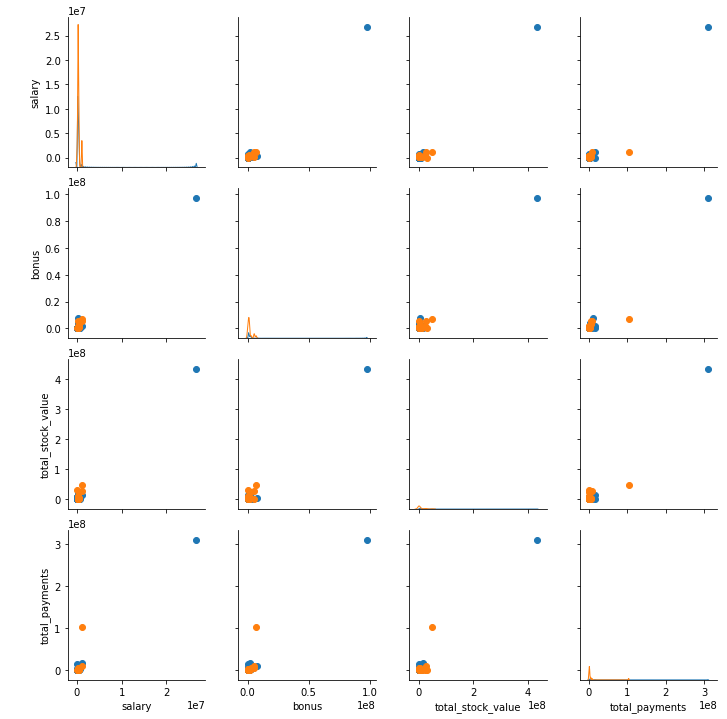

In [7]:
g = sns.PairGrid(df, vars=['salary','bonus','total_stock_value','total_payments'],
                hue='poi')
g.map_upper(plt.scatter)
g.map_lower(plt.scatter)
g.map_diag(sns.kdeplot, lw=1)

Who is this person that makes more than 23M in salary ??? 

In [8]:
df.loc[df['salary'] > 2000000]

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
TOTAL,"26,704,229.00","2,007.11","32,083,396.00","309,886,585.00","311,764,000.00","97,343,619.00","130,322,299.00","1,058.53","-7,576,788.00","434,509,511.00",...,"83,925,000.00",668.76,"42,667,589.00",36.28,False,"1,398,517.00","-27,992,891.00","48,521,928.00",NaN,58.50


Our dataset contains the **TOTAL** entry. Lets remove it along with other entry that is not a person

In [9]:
df.drop(axis=0, labels=['TOTAL', 'THE TRAVEL AGENCY IN THE PARK'], inplace=True)

According to the [official definition of outlier](https://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm) we have the following for non-POI

In [10]:
IQR = df.quantile(q=0.75) - df.quantile(q=0.25)
first_quartile = df.quantile(q=0.25)
third_quartile = df.quantile(q=0.75)
outliers = df[((df>(third_quartile + 1.5*IQR)) | (df<(first_quartile - 1.5*IQR))) & df_nonpoi].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(10)

FREVERT MARK A        13
LAVORATO JOHN J        9
KEAN STEVEN J          8
BAXTER JOHN C          8
HAEDICKE MARK E        8
KITCHEN LOUISE         7
WHALLEY LAWRENCE G     7
ALLEN PHILLIP K        6
BECK SALLY W           6
BUY RICHARD B          6
dtype: int64

These are non-POIs outliers. Since this dataset already has few datapoints I don't think we shall proceed removing outliers for now. I didn't look for outliers that are POIs because we have way few of them so each one is very valuable to our model.
## Model performance baseline
Lets run some classifiers to see how they perform on the dataset. I'll start with a DecisionTree, LogisticRegression and Naive Bayes algorithms.

In [11]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import tester

enron_dict = df.to_dict(orient='index')
### The first feature must be "poi".
features_list = ['poi']
features_list.extend(financial_features)
features_list.extend(email_features)

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [12]:
def assess_classifier(clf, dataset, features_list):
    tester.dump_classifier_and_data(clf, dataset, features_list)
    tester.main()

In [13]:
def evaluate_clfs(dataset, features):
    clf1 = DecisionTreeClassifier()
    assess_classifier(clf1, dataset, features)
    
    clf2 = LogisticRegression()
    assess_classifier(clf2, dataset, features)
    
    clf3 = GaussianNB()
    assess_classifier(clf3, dataset, features)
    
# evaluate clfs with raw data for baseline
evaluate_clfs(enron_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.82127	Precision: 0.32829	Recall: 0.32550	F1: 0.32689	F2: 0.32605
	Total predictions: 15000	True positives:  651	False positives: 1332	False negatives: 1349	True negatives: 11668

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.81587	Precision: 0.23975	Recall: 0.17550	F1: 0.20266	F2: 0.18544
	Total predictions: 15000	True positives:  351	False positives: 1113	False negatives: 1649	True negatives: 11887

G

As we can see the DecisionTree got the best score followed closely by Naive Bayes and the LogisticRegression was the worse.
### Impact of outliers
Now lets test how the classifiers performs without the outliers we discovered

In [14]:
# evaluate again removing outliers
df.drop(axis=0, labels=['FREVERT MARK A'], inplace=True)
enron_dict = df.to_dict(orient='index')
evaluate_clfs(enron_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.83027	Precision: 0.35942	Recall: 0.34900	F1: 0.35413	F2: 0.35104
	Total predictions: 15000	True positives:  698	False positives: 1244	False negatives: 1302	True negatives: 11756

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.81193	Precision: 0.23257	Recall: 0.17850	F1: 0.20198	F2: 0.18721
	Total predictions: 15000	True positives:  357	False positives: 1178	False negatives: 1643	True negatives: 11822

G

We got some boost for the DecisionTree lets remove some more outliers 

In [15]:
# lets remove some more outliers
df.drop(axis=0, labels=['LAVORATO JOHN J', 'HAEDICKE MARK E', 'BAXTER JOHN C', 'KEAN STEVEN J'], inplace=True)
enron_dict = df.to_dict(orient='index')
evaluate_clfs(enron_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.82679	Precision: 0.38569	Recall: 0.35850	F1: 0.37160	F2: 0.36363
	Total predictions: 14000	True positives:  717	False positives: 1142	False negatives: 1283	True negatives: 10858

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.81471	Precision: 0.28846	Recall: 0.20250	F1: 0.23796	F2: 0.21533
	Total predictions: 14000	True positives:  405	False positives:  999	False negatives: 1595	True negatives: 11001

G

We saw that removing outliers indeed had a good benefit for the classifiers as expected, being the DecisionTree the algorithm that got most benefit from it
## Optimize Feature Selection/Engineering
We're going to proceed attempting to increase our _F1 score_ by selecting the most important features. First lets remove the ones with most empty entries and the email features. The reason for that is because the email features had very low importance for the DecisionTree.

In [16]:
# evaluate again removing the follwing features
# loan_advances                142
# director_fees                129
# restricted_stock_deferred    128
# deferral_payments            107
financial_features = ['salary', 'total_payments', 'exercised_stock_options', 'bonus','restricted_stock',
                      'total_stock_value', 'expenses', 'other', 'deferred_income', 'long_term_incentive']

features_list = ['poi']
features_list.extend(financial_features)
evaluate_clfs(enron_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.84486	Precision: 0.44935	Recall: 0.38150	F1: 0.41266	F2: 0.39338
	Total predictions: 14000	True positives:  763	False positives:  935	False negatives: 1237	True negatives: 11065

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
	Accuracy: 0.67500	Precision: 0.10938	Recall: 0.17850	F1: 0.13564	F2: 0.15847
	Total predictions: 14000	True positives:  357	False positives: 2907	False negatives: 1643	True negatives: 9093

Ga

## Baseline results
### Raw run
Using all the features and without removing any outliers of the dataset we got the following results:
- Decision Tree: Accuracy: 0.81907	Precision: 0.32327	Recall: 0.32650	**F1: 0.32903**	F2: 0.32585
- Logistic Regression: Accuracy: 0.81333	Precision: 0.23580	Recall: 0.17850	F1: 0.20052	F2: 0.18762
- GaussianNB: Accuracy: 0.74953	Precision: 0.23642	Recall: 0.39400	**F1: 0.29552**	F2: 0.34766

### Remove the top outlier
The Tree did very good as well as the NB. Now lets try to remove the top outlier:
- Decision Tree: Accuracy: 0.82913	Precision: 0.35689	Recall: 0.35100	**0.36179**	F2: 0.35216
- Logistic Regression: Accuracy: 0.81320	Precision: 0.23549	Recall: 0.17850	F1: 0.20478	F2: 0.18758
- GaussianNB: Accuracy: 0.77487	Precision: 0.26002	Recall: 0.37300	**F1: 0.30643**	F2: 0.34318

### Remove more outliers
Now lets remove some more outliers:
- Decision Tree: Accuracy: 0.84429	Precision: 0.44668	Recall: 0.37700	**F1: 0.38058**	F2: 0.38914
- Logistic Regression: Accuracy: 0.67493	Precision: 0.10934	Recall: 0.17850	F1: 0.23304	F2: 0.15846
- GaussianNB: Accuracy: 0.85021	Precision: 0.46925	Recall: 0.37000	**F1: 0.29749**	F2: 0.38634

### Remove useless features
Now lets remove the features with most empty rows and also all the emails_features:
- Decision Tree: Accuracy: 0.81507	Precision: 0.29802	Recall: 0.28550	**F1: 0.41320**	F2: 0.28792
- Logistic Regression: Accuracy: 0.65947	Precision: 0.08758	Recall: 0.16500	F1: 0.13561	F2: 0.14021
- GaussianNB: Accuracy: 0.85233	Precision: 0.43113	Recall: 0.33650	**F1: 0.41375**	F2: 0.35195

### Conclusion
Both Tree and NB didn't get way better by removing those points. Both performed well with outliers removed and less features now lets move for some feature engineering.
## Feature engineering 
I want to test the hypothesis that the likely POI would be among the wealthiest people in Enron. Lets create a new feature called _wealth_ that is the sum of: *total_payments* and *total_stock_value*

In [17]:
df['wealth'] = df['total_payments'] + df['total_stock_value']
# add the new features and test the classifiers
features_list.extend(['wealth'])
enron_dict = df.to_dict(orient='index')

def evaluate_best_clfs(dataset, features):
    clf1 = DecisionTreeClassifier()
    assess_classifier(clf1, dataset, features)
    
    clf2 = GaussianNB()
    assess_classifier(clf2, dataset, features)

evaluate_best_clfs(enron_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.84393	Precision: 0.44523	Recall: 0.37600	F1: 0.40770	F2: 0.38807
	Total predictions: 14000	True positives:  752	False positives:  937	False negatives: 1248	True negatives: 11063

GaussianNB(priors=None)
	Accuracy: 0.85186	Precision: 0.47569	Recall: 0.36200	F1: 0.41113	F2: 0.38017
	Total predictions: 14000	True positives:  724	False positives:  798	False negatives: 1276	True negatives: 11202



- Tree: Accuracy: 0.82907	Precision: 0.39053	Recall: 0.35050	**F1: 0.40462**	F2: 0.35784
- GNB: Accuracy: 0.85921	Precision: 0.50941	Recall: 0.39250	**F1: 0.41113**	F2: 0.41138

It seems that the feature didn't help much. Lets try to understand why with the help of a box-plot

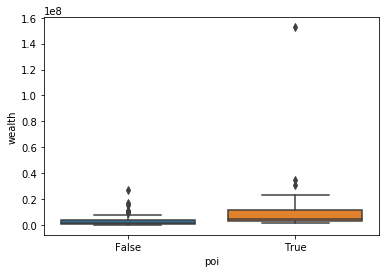

In [18]:
sns.boxplot(x='poi', y='wealth', data=df)

As we can see there is an outlier there that is causing our models to not perform better with the new feature. I've tested it again by removing Mr. Lay from the dataset and we got a nice bump around **F1: 0.48** for GaussianNB algorithm. But since this datapoint is a valid person I won't remove it by the sake of scoring. I've also tested an algorithm that is less impacted by outliers, such RandomForest, but didn't get any better.
### Scaling
This is not necessary since we're not using any algorithm that calculates distances between datapoints.

### Feature Selection
We're going to use the selectKbest algorithm to help us find which features are most contributing for the score of our model

In [19]:
from sklearn.feature_selection import SelectKBest

financial_features = ['salary', 'deferral_payments', 'total_payments', 'exercised_stock_options', 'bonus',
                      'restricted_stock', 'restricted_stock_deferred', 'total_stock_value', 'expenses',
                      'loan_advances', 'other', 'director_fees', 'deferred_income', 'long_term_incentive',
                      'wealth']
email_features = ['to_messages', 'shared_receipt_with_poi', 'from_messages', 'from_this_person_to_poi',
                  'from_poi_to_this_person']

feat = financial_features
feat.extend(email_features)

X = df[feat].copy()
y = df.poi

# K-best features
k_best = SelectKBest()
k_best.fit(X, y)

results_list = zip(k_best.get_support(), X.columns, k_best.scores_)
results_list = sorted(results_list, key=lambda x: x[2], reverse=True)
results_list

[(True, 'bonus', 33.79096110294173),
 (True, 'total_stock_value', 26.508413753622087),
 (True, 'exercised_stock_options', 26.464044531327755),
 (True, 'salary', 25.39201175838935),
 (True, 'wealth', 18.605473030982495),
 (True, 'deferred_income', 17.79222628461537),
 (True, 'shared_receipt_with_poi', 14.656990496527813),
 (True, 'from_poi_to_this_person', 13.435220006206515),
 (True, 'long_term_incentive', 12.777941606214178),
 (True, 'restricted_stock', 10.727034552836722),
 (False, 'total_payments', 9.549350670872046),
 (False, 'other', 7.748177648269289),
 (False, 'loan_advances', 7.004820860432903),
 (False, 'expenses', 6.503007669290257),
 (False, 'from_this_person_to_poi', 4.976006788999146),
 (False, 'director_fees', 2.2044537287158033),
 (False, 'to_messages', 1.68344709039327),
 (False, 'from_messages', 0.7793455379414735),
 (False, 'restricted_stock_deferred', 0.07198185498991817),
 (False, 'deferral_payments', 0.01616554853366679)]

Our new feature didn't bring much to the table. Just happen that its score is the mean of the 2 features we chose to create *wealth*. These features is very similar with the ones we have been working so far except for *expenses* and *from_poi_to_this_person* which is an email feature.

In [20]:
features_list = ['poi'] + [x[1] for x in results_list[:10]]
evaluate_best_clfs(enron_dict, features_list)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
	Accuracy: 0.83029	Precision: 0.39450	Recall: 0.35150	F1: 0.37176	F2: 0.35933
	Total predictions: 14000	True positives:  703	False positives: 1079	False negatives: 1297	True negatives: 10921

GaussianNB(priors=None)
	Accuracy: 0.87164	Precision: 0.56404	Recall: 0.44700	F1: 0.49874	F2: 0.46635
	Total predictions: 14000	True positives:  894	False positives:  691	False negatives: 1106	True negatives: 11309



- Tree: Accuracy: 0.82071	Precision: 0.35690	Recall: 0.31800	**F1: 0.36919**	F2: 0.32509
- GNB: Accuracy: 0.85757	Precision: 0.50198	Recall: 0.38000	**F1: 0.49874**	F2: 0.39941

SelectKBest boosted our GaussianNB's F1 score to 0.49 but worsen the F1 score of our DecisionTree. 

## Hyperparameter Optimization
Until now we have been trying to leverage our dataset (by removing outliers) and features (by feature engineering/selection) to improve our score. Now is time for us investigate the best parameters for our classifiers and for this task we're going to perform a grid search. As the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) says and I quote: grid search is an "*exhaustive search over specified parameter values for an estimator*". So lets say we want to find the best parameters for our DecisionTree which means basically the setup of parameters that score better on our dataset. So we setup a *parameter grid* from which the search will be conducted and GridSearchCV will return the best parameters using cross validation.

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline(steps=[('select_best', SelectKBest()),
                       ('clf', DecisionTreeClassifier())])
# conduct the search w/o selectKBest first
param_grid = [
    {
        'select_best': [None],
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_split': [2, 4, 6, 8, 10, 20],
        'clf__max_depth': [None, 5, 10, 15, 20],
        'clf__max_features': [None, 'sqrt', 'log2', 'auto']
    },
    {
        'select_best__k': [5, 7, 10],
        'clf__criterion': ['gini', 'entropy'],
        'clf__min_samples_split': [2, 4, 6, 8, 10, 20],
        'clf__max_depth': [None, 5, 10, 15, 20],
        'clf__max_features': [None, 'sqrt', 'log2', 'auto']
    }
]
# perform the search. the results might differ from each run
tree_clf = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=10)
tree_clf.fit(X, y)
tree_clf.best_params_

# features = ['poi'] + [x[1] for x in sorted(zip(map(lambda x: round(x, 4), tree_clf.best_estimator_.named_steps['clf'].feature_importances_), X.columns), reverse=True)]
# features

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

{'clf__criterion': 'gini',
 'clf__max_depth': 20,
 'clf__max_features': 'log2',
 'clf__min_samples_split': 8,
 'select_best__k': 10}

Additionally we combined the search with a pipeline to test the performance with/without SelectKBest. Next we will do the same for GaussianNB

In [22]:
pipe = Pipeline(steps=[('select_best', SelectKBest()),
                       ('clf', GaussianNB())])
param_grid = [{'select_best': [None]}, {'select_best__k': [5, 10, 15, 20]}]

bayes_clf = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=10)
bayes_clf.fit(X, y)
bayes_clf.best_params_

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/m

{'select_best__k': 10}

In [23]:
print bayes_clf.best_estimator_.named_steps['clf']
print bayes_clf.best_estimator_.named_steps['select_best']
print tree_clf.best_estimator_.named_steps['clf']
print tree_clf.best_estimator_.named_steps['select_best']

GaussianNB(priors=None)
SelectKBest(k=10, score_func=<function f_classif at 0x1a240f0b18>)
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
SelectKBest(k=10, score_func=<function f_classif at 0x1a240f0b18>)


### Results
- GaussianNB: after some runs the *k=10* is the parameter that scored better with this algorithm
- DecisionTree: the parameter may vary from each run except for not using SelectKBest, without this estimator the tree performed better for most of the runs

## Validate and Evaluate
### Evaluation
To evaluate the models performance we're going to use the **F1 score** which is the harmonic mean of **precision** and **recall**, which in turn are defined in the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) as:
- precison: *the ratio `tp / (tp + fp)` where `tp` is the number of true positives and `fp` the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative*. In our context means the ability of the classifier not to label a non-POI as POI. As can be noted as much as `fp` is close to 0 we're going to have a precision close to 1, which is good.
- recall: *the ratio `tp / (tp + fn)` where `tp` is the number of true positives and `fn` the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples*. In our context means to find all the POIs present in the dataset. Again as much as `fn` is close to 0 we're going to have a recall close to 1, which is good.

### Validation
To validate our models the `tester.py` uses *StratifiedShuffleSplit* which assures that our models will be trained/tested with different portions of our dataset several times (folds) preventing that a score is made upon a data that it already saw before. Shuffling the training/test portions of the data helps the model to build generalization.

In [24]:
best_select = bayes_clf.best_estimator_.named_steps['select_best']
best_clf = bayes_clf.best_estimator_.named_steps['clf']

tuned_bayes_clf = Pipeline([
    ('select_features', best_select),
    ('classify', best_clf)
])
features = ['poi'] + feat
assess_classifier(tuned_bayes_clf, enron_dict, features_list)

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x1a240f0b18>)), ('classify', GaussianNB(priors=None))])
	Accuracy: 0.87164	Precision: 0.56404	Recall: 0.44700	F1: 0.49874	F2: 0.46635
	Total predictions: 14000	True positives:  894	False positives:  691	False negatives: 1106	True negatives: 11309



In [25]:
best_select = tree_clf.best_estimator_.named_steps['select_best']
best_clf = tree_clf.best_estimator_.named_steps['clf']

tuned_tree_clf = Pipeline([
    ('select_features', best_select),
    ('classify', best_clf)
])

assess_classifier(tuned_tree_clf, enron_dict, features)

/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [9] are constant.
  UserWarning)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [9] are constant.
  UserWarning)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [9] are constant.
  UserWarning)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [9] are constant.
  UserWarning)
/Users/Ferraz/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [9] are constant.
  UserWarning)
/Users/Ferraz/anacond

Pipeline(memory=None,
     steps=[('select_features', SelectKBest(k=10, score_func=<function f_classif at 0x1a240f0b18>)), ('classify', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
            max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=8,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))])
	Accuracy: 0.83264	Precision: 0.39749	Recall: 0.33250	F1: 0.36210	F2: 0.34374
	Total predictions: 14000	True positives:  665	False positives: 1008	False negatives: 1335	True negatives: 10992



- DecisionTree: Accuracy: 0.83657	Precision: 0.41771	Recall: 0.36550	**F1: 0.36210**	F2: 0.37487
- GaussianNB: Accuracy: 0.85536	Precision: 0.49179	Recall: 0.37450	**F1: 0.49874**	F2: 0.39326

A precision score of 0.56404 means that of the individuals labeled by my model as POI, 56.4% of them were indeed POI. A recall score of 0.44700 means that my model identified 44.7% of POI present in the entire dataset.



## Final thoughts
At the end the GaussianNB performed better although I'm not very satisfied with the score. We have to take into the account the small number of POIs in the dataset which also have some outliers that might cause problems for the classifiers. We can see that the quality of the dataset is responsible for the biggest boosts we had in our models proving that feature selecting/engineering and outliers treatment plays greater role compared to hyperparameter tunning when it comes to model performance.
### Materials that served as reference
- https://medium.com/@williamkoehrsen/machine-learning-with-python-on-the-enron-dataset-8d71015be26d